<a href="https://colab.research.google.com/github/taliafabs/sta496/blob/main/VoteChoice_RaceDep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Logistic Regression Vote Choice Models Using Recent U.S. Presidential Election Data


## Introduction

## Data

The datasets used for this project are the 2020 and 2024 CES survey datasets, obtained from Harvard Dataverse. They can be found at the following links:
* 2024:
* 2020:

### Loading the data

In [1]:
# Workplace setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pymc as pm

In [2]:
# loading the data
from google.colab import drive
drive.mount('/content/drive')

# 2024
ces24 = pd.read_stata("/content/drive/MyDrive/STA496/Datasets/CES24_Common.dta")

# 2020
ces20 = pd.read_stata("/content/drive/MyDrive/STA496/Datasets/CES20_Common_OUTPUT_vv.dta")

Mounted at /content/drive


In [5]:
# data preparation
ces24_subset = ces24[['gender4', 'race', 'hispanic', 'educ', 'marstat', 'inputstate', 'region', 'birthyr',
                  'ownhome', 'urbancity', 'industry',
                  'religpew', 'pew_religimp', 'pew_churatd', 'pew_prayer',
                  'CC24_361b', 'CC24_363', 'CC24_364a', 'CC24_364b', 'presvote20post', 'pid3', 'pid7'
                  ]]

ces20_subset = ces20[['gender', 'race', 'hispanic', 'educ', 'marstat', 'inputstate', 'region', 'birthyr',
                      'ownhome', 'urbancity', 'industryclass',
                      'religpew', 'pew_religimp', 'pew_churatd', 'pew_prayer',
                      'votereg', 'votereg_f','CC20_364a', 'CC20_364b', 'presvote16post', 'pid3', 'pid7']]

# only include trump and biden/harris
ces24_subset = ces24_subset[
    (ces24_subset['CC24_364a'] == "Kamala Harris (Democrat)") |
    (ces24_subset['CC24_364a'] == "Donald Trump (Republican)")
]

ces20_subset = ces20_subset[
    (ces20_subset['CC20_364a'] == "Joe Biden (Democrat)") |
    (ces20_subset['CC20_364a'] == "Donald Trump (Republican)")
]

# create vote_trump binary variable
ces24_subset['vote_trump'] = np.where(ces24_subset['CC24_364a'] == 'Donald Trump (Republican)', 1, 0)
ces20_subset['vote_trump'] = np.where(ces20_subset['CC20_364a'] == 'Donald Trump (Republican)', 1, 0)

# columns
ces24_subset['age'] = 2024 - ces24_subset['birthyr']

ces24_subset['age_bracket'] = pd.cut(
    ces24_subset['age'],
    bins=[17, 24, 34, 44, 54, 64, 74, 100],
    labels=[
        '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+'
    ]
)

ces24_subset = ces24_subset[[
    'vote_trump',
    'age_bracket',
    'gender4',
    'race',
    # 'hispanic',
    'educ',
    # 'marstat',
    # 'inputstate',
    'region',
    'urbancity',
    'religpew',
    # 'pew_religimp',
    # 'pew_churatd',
    'pid3'
]]

# 2020
ces20_subset['age'] = 2020 - ces20_subset['birthyr']

ces20_subset['age_bracket'] = pd.cut(
    ces20_subset['age'],
    bins=[17, 24, 34, 44, 54, 64, 74, 100],
    labels=[
        '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+'
    ]
)

ces20_subset = ces20_subset[[
    'vote_trump',
    'age_bracket',
    'gender',
    'race',
    # 'hispanic',
    'educ',
    # 'marstat',
    # 'inputstate',
    'region',
    'urbancity',
    'religpew',
    # 'pew_religimp',
    # 'pew_churatd',
    'pid3'
]]

# categorical predictors
predictors24 = ces24_subset.columns.drop('vote_trump')
ces24_subset[predictors24] = ces24_subset[predictors24].astype('category')
predictors20 = ces20_subset.columns.drop('vote_trump')
ces20_subset[predictors20] = ces20_subset[predictors20].astype('category')

ces24_subset.dropna(inplace=True)
ces20_subset.dropna(inplace=True)

# dropping race
ces24_subset_no_race = ces24_subset.drop(columns=['race'])
ces20_subset_no_race = ces20_subset.drop(columns=['race'])

/tmp/ipython-input-5-430267679.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ces20_subset[predictors20] = ces20_subset[predictors20].astype('category')
/tmp/ipython-input-5-430267679.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ces20_subset.dropna(inplace=True)


In [7]:
# Dummy variables and interaction terms

race_dummies_24 = pd.get_dummies(ces24_subset['race'], prefix='race', drop_first=True)
gender_dummies_24 = pd.get_dummies(ces24_subset['gender4'], prefix='gender', drop_first=True)
education_dummies_24 = pd.get_dummies(ces24_subset['educ'], prefix='educ', drop_first=True)

race_dummies_20 = pd.get_dummies(ces20_subset['race'], prefix='race', drop_first=True)
gender_dummies_20 = pd.get_dummies(ces20_subset['gender'], prefix='gender', drop_first=True)
education_dummies_20 = pd.get_dummies(ces20_subset['educ'], prefix='educ', drop_first=True)

ces24_subset_full = pd.get_dummies(ces24_subset, drop_first=True)
ces20_subset_full = pd.get_dummies(ces20_subset, drop_first=True)

interaction_terms_24 = pd.DataFrame()
interaction_terms_20 = pd.DataFrame()

# 2024 interaction dummies
for col1 in race_dummies_24.columns: # go thru every race dummy
    for col2 in gender_dummies_24.columns: # race * gender
        interaction_terms_24[f'{col1}_{col2}'] = race_dummies_24[col1] * gender_dummies_24[col2]
    for col3 in education_dummies_24.columns: # race * education
        interaction_terms_24[f'{col1}_{col3}'] = race_dummies_24[col1] * education_dummies_24[col3]

# 2020 interaction dummies
for col1 in race_dummies_20.columns: # go through every race dummy
    for col2 in gender_dummies_20.columns: # race * gender
        interaction_terms_20[f'{col1}_{col2}'] = race_dummies_20[col1] * gender_dummies_20[col2]
    for col3 in education_dummies_20.columns: # race * education
        interaction_terms_20[f'{col1}_{col3}'] = race_dummies_20[col1] * education_dummies_20[col3]


## Machine Learning (ML) Approach

### Setup

In [8]:
# full model
# combine data frames for full ML models
# do not drop main effects
df_24_full_model = pd.concat([
    ces24_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional; drops main predictors
    race_dummies_24,
    gender_dummies_24,
    education_dummies_24,
    interaction_terms_24
], axis=1)

df_20_full_model = pd.concat([
    ces20_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional
    race_dummies_20,
    gender_dummies_20,
    education_dummies_20,
    interaction_terms_20
], axis=1)

In [10]:
# model 1
# combine data frames for model with no race main but race interactions

df_24_model1 = pd.concat([
    ces24_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional; drops main predictors
    # race_dummies_24, DROP RACE MAIN EFFECT
    gender_dummies_24,
    education_dummies_24,
    interaction_terms_24
], axis=1)

df_20_model1 = pd.concat([
    ces20_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional
    gender_dummies_20,
    education_dummies_20,
    interaction_terms_20
], axis=1)

In [ ]:
# model 2

In [16]:
# model with no race at all (no main effect, no interactions)
df_24_no_race = pd.concat([
    ces24_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional
    gender_dummies_24,
    education_dummies_24
    ], axis=1)

df_20_no_race = pd.concat([
    ces20_subset_full.drop(columns=['race', 'gender', 'educ'], errors='ignore'),  # optional
    gender_dummies_20,
    education_dummies_20
    ], axis=1)

### Models

I will evaluate the performance of the following logistic regression models on the CES 2020 and 2024 datasets:

##### 2024

In [5]:
# full model
X_24 = df_24_full_model.drop(columns=['vote_trump'])
y_24 = df_24_full_model['vote_trump']

# train test split
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.25, random_state=42)

# train
model0_ml = LogisticRegression()
model0_ml.fit(X_train_24, y_train_24)

# predict
y_pred_24 = model0_ml.predict(X_test_24)

# evaluate
print(classification_report(y_test_24, y_pred_24))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1609
           1       0.85      0.79      0.82       703

    accuracy                           0.89      2312
   macro avg       0.88      0.87      0.87      2312
weighted avg       0.89      0.89      0.89      2312



In [11]:
# model 1: reduced model with no race as a main effect
X_24 = df_24_model1.drop(columns=['vote_trump'])
y_24 = df_24_model1['vote_trump']

# train test split
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.25, random_state=42)

model1_ml = LogisticRegression()
model1_ml.fit(X_train_24, y_train_24)

# predict
y_pred_24 = model1_ml.predict(X_test_24)

# validation accuracy
print(classification_report(y_test_24, y_pred_24))
# removing race as a main effect does not really change the ML model's performance
# this is worth removing because the validation accuracy does not go down but model is simplified
# simplifying the model does not compromise performance

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1609
           1       0.85      0.79      0.82       703

    accuracy                           0.89      2312
   macro avg       0.88      0.86      0.87      2312
weighted avg       0.89      0.89      0.89      2312



In [20]:
# no race model
X_24 = df_24_no_race.drop(columns=['vote_trump'])
y_24 = df_24_no_race['vote_trump']

X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X_24, y_24, test_size=0.25, random_state=42)
model = LogisticRegression()
model.fit(X_train_24, y_train_24)

# predict
y_pred_24 = model.predict(X_test_24)

print(classification_report(y_test_24, y_pred_24))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1609
           1       0.85      0.79      0.82       703

    accuracy                           0.89      2312
   macro avg       0.88      0.87      0.87      2312
weighted avg       0.89      0.89      0.89      2312



##### 2020

In [12]:
# 2020 full model
X_20 = df_20_full_model.drop(columns=['vote_trump'])
y_20 = df_20_full_model['vote_trump']

# train test split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.25, random_state=42)
model0_ml = LogisticRegression()
model0_ml.fit(X_train_20, y_train_20)

# predict
y_pred_20 = model0_ml.predict(X_test_20)

# report accuracy
print(classification_report(y_test_20, y_pred_20))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2227
           1       0.85      0.71      0.77       634

    accuracy                           0.91      2861
   macro avg       0.89      0.84      0.86      2861
weighted avg       0.91      0.91      0.91      2861



In [14]:
# 2020 model 1
X_20 = df_20_model1.drop(columns=['vote_trump'])
y_20 = df_20_model1['vote_trump']

# train test split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.25, random_state=42)
model1_ml = LogisticRegression()
model1_ml.fit(X_train_20, y_train_20)

# predict
y_pred_20 = model1_ml.predict(X_test_20)

# report accuracy
print(classification_report(y_test_20, y_pred_20))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2227
           1       0.85      0.71      0.77       634

    accuracy                           0.91      2861
   macro avg       0.89      0.84      0.86      2861
weighted avg       0.91      0.91      0.90      2861



### Results

## Frequentist Approach

### Setup
Likelihood ratio test will compare nested logistic GLMs to determine whether the more complex model provides a significantly better explanation of the data than the simpler model.

Complex model:

\begin{align*}
\frac{p(\text{vote_trump})}{1 - p(\text{(vote_trump})} = \beta_0 + \beta_1 \cdot \text{race} + \beta_2 \cdot \text{gender} + \beta_3 \cdot \text{educ} + \beta_4 \cdot \text{region} + \beta_5 \cdot \text{urbancity} + \beta_6 \cdot \text{religion} + \beta_7 \cdot \text{party_id} + \beta_8 \cdot (\text{race} \times \text{gender}) + \beta_9 \cdot (\text{race} \times \text{educ})
\end{align*}

Reduced models:

remove race interactions
\begin{align*}
\frac{p(\text{vote_trump})}{1 - p(\text{(vote_trump})} = \beta_0 + \beta_1 \cdot \text{race} + \beta_2 \cdot \text{gender} + \beta_3 \cdot \text{educ} + \beta_4 \cdot \text{region} + \beta_5 \cdot \text{urbancity} + \beta_6 \cdot \text{religion} + \beta_7 \cdot \text{party_id}
\end{align*}

remove race main effect and interactions
\begin{align*}
\frac{p(\text{vote_trump})}{1 - p(\text{(vote_trump})} = \beta_0 + \beta_1 \cdot \text{race} + \beta_2 \cdot \text{gender} + \beta_3 \cdot \text{educ} + \beta_4 \cdot \text{region} + \beta_5 \cdot \text{urbancity} + \beta_6 \cdot \text{religion} + \beta_7 \cdot \text{party_id}
\end{align*}

### Models

Likelihood ratio test and frequentist model evals
Is the race main effect significant?
How did the significance of race change between 2020 and 2024?

In [22]:
# 2024 include race as main effect with race
ces24_model1 = smf.logit("vote_trump ~ C(race) + C(gender4) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces24_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.226922
         Iterations 9


In [17]:
# remove race from the model
ces24_model2 = smf.logit("vote_trump ~  C(gender4) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces24_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.228995
         Iterations 9


In [18]:
# 2020 include race as main effect
ces20_model1 = smf.logit("vote_trump ~ C(race) + C(gender) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces20_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.231126
         Iterations 9


In [31]:
# 2020 drop race main effect
ces20_model2 = smf.logit("vote_trump ~  C(gender) + C(educ) + C(age_bracket) + C(region) + C(urbancity) + C(religpew) + C(pid3)",
                         data=ces20_subset).fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.235632
         Iterations 8


### Results

In [ ]:
print(ces24_model1.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                 9242
Model:                          Logit   Df Residuals:                     9198
Method:                           MLE   Df Model:                           43
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.6336
Time:                        00:17:25   Log-Likelihood:                -2094.5
converged:                       True   LL-Null:                       -5716.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -3.9217      0.418     -9.379      0.000      -4.741      -3.102
C(race)[T.Black]                         

In [24]:
# Assuming ces24_model1 is a fitted statsmodels Logit model
params = ces24_model1.params
conf = ces24_model1.conf_int()
conf.columns = ['2.5%', '97.5%']

# Exponentiate to get odds ratios and CIs
odds_ratios = np.exp(params)
conf_exp = np.exp(conf)

# Combine into a readable table
summary_table = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5% CI': conf_exp['2.5%'],
    '97.5% CI': conf_exp['97.5%'],
    'p-value': ces24_model1.pvalues
})

print(summary_table)


                                           Odds Ratio     2.5% CI  \
Intercept                                    0.019806    0.008734   
C(race)[T.Black]                             0.416685    0.291658   
C(race)[T.Hispanic]                          0.673788    0.472321   
C(race)[T.Asian]                             0.810989    0.475737   
C(race)[T.Native American]                   1.587377    0.735064   
C(race)[T.Two or more races]                 0.726866    0.467056   
C(race)[T.Other]                             1.741572    1.043898   
C(race)[T.Middle Eastern]                    2.450959    0.454445   
C(gender4)[T.Woman]                          0.816175    0.692785   
C(gender4)[T.Non-binary]                     0.143767    0.024583   
C(gender4)[T.Other]                          0.217193    0.024574   
C(educ)[T.High school graduate]              0.546116    0.282254   
C(educ)[T.Some college]                      0.495575    0.258101   
C(educ)[T.2-year]                 

In [ ]:
print(ces24_model2.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                 9242
Model:                          Logit   Df Residuals:                     9205
Method:                           MLE   Df Model:                           36
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                  0.6303
Time:                        00:17:35   Log-Likelihood:                -2113.2
converged:                       True   LL-Null:                       -5716.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -4.1760      0.413    -10.119      0.000      -4.985      -3.367
C(gender4)[T.Woman]                      

In [20]:
print(ces20_model1.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                11444
Model:                          Logit   Df Residuals:                    11402
Method:                           MLE   Df Model:                           41
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                  0.5604
Time:                        17:05:59   Log-Likelihood:                -2645.0
converged:                       True   LL-Null:                       -6016.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -3.6780      0.334    -11.007      0.000      -4.333      -3.023
C(race)[T.Black]                         

In [21]:
print(ces20_model2.summary())

                           Logit Regression Results                           
Dep. Variable:             vote_trump   No. Observations:                11444
Model:                          Logit   Df Residuals:                    11409
Method:                           MLE   Df Model:                           34
Date:                Thu, 26 Jun 2025   Pseudo R-squ.:                  0.5518
Time:                        17:06:04   Log-Likelihood:                -2696.6
converged:                       True   LL-Null:                       -6016.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -4.1829      0.322    -12.985      0.000      -4.814      -3.552
C(gender)[T.Female]                      

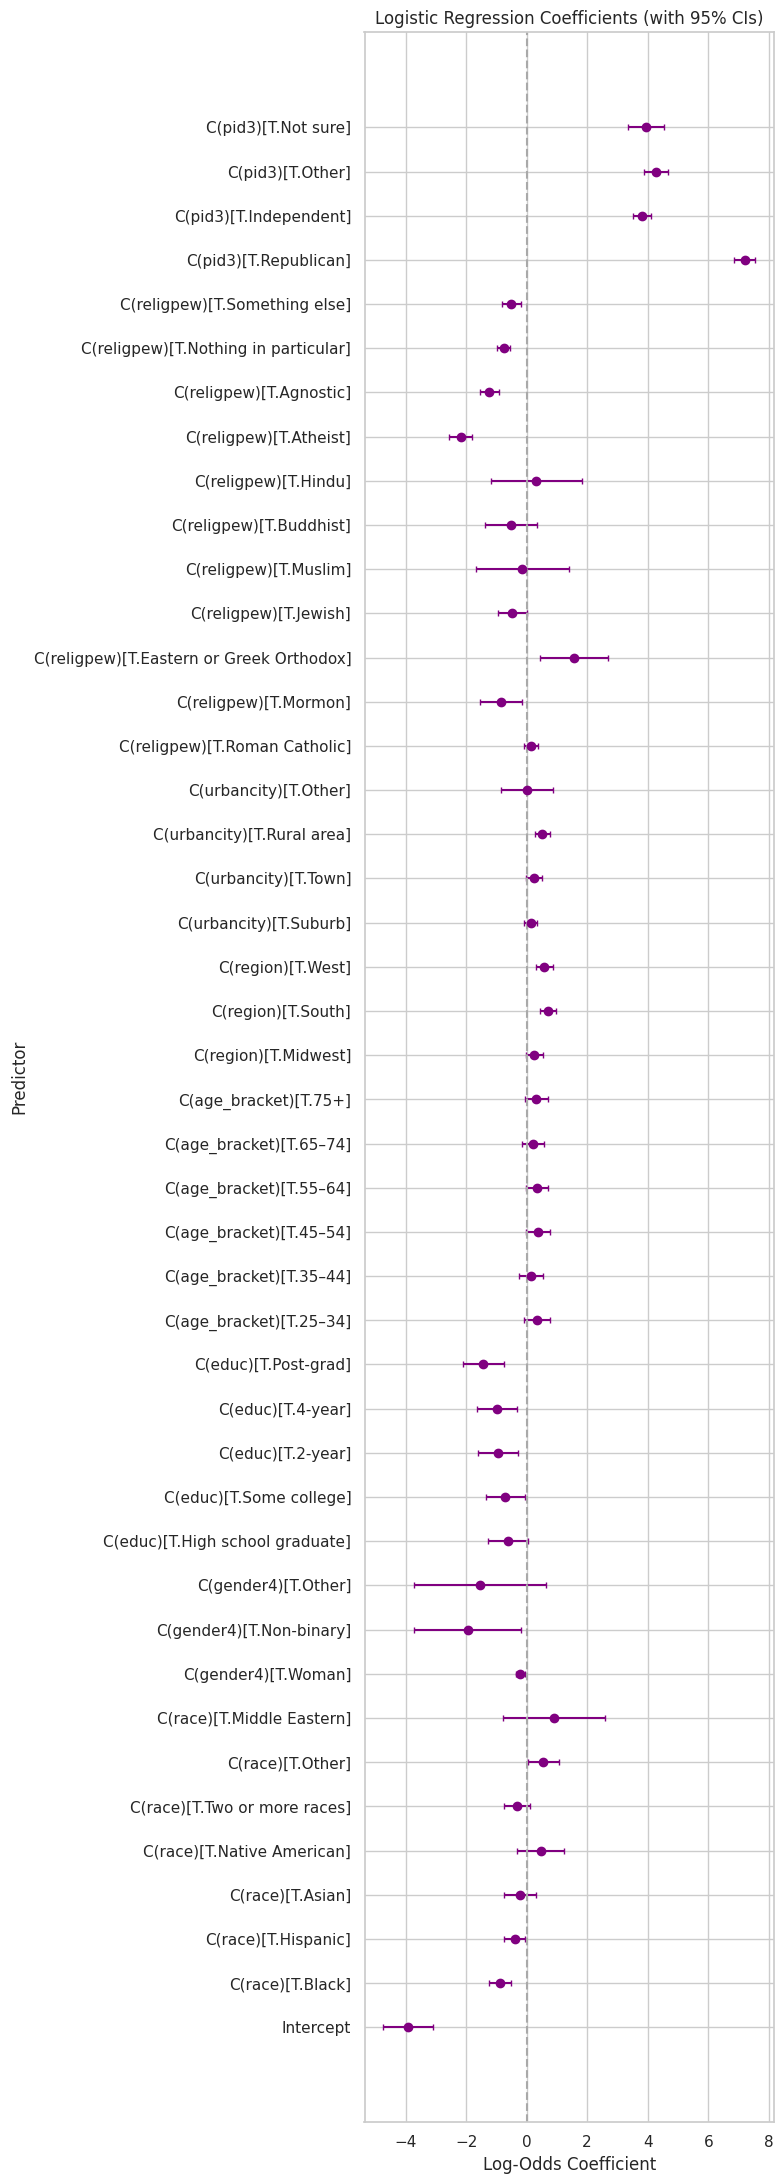

In [39]:
# error bar visualizations (I used chat gpt to help format these)
params = ces24_model1.params
conf = ces24_model1.conf_int()
conf.columns = ['CI Lower', 'CI Upper']

coef_df = pd.DataFrame({
    'Coefficient': params,
    'CI Lower': conf['CI Lower'],
    'CI Upper': conf['CI Upper'],
})
coef_df['Variable'] = coef_df.index

# only include race params??
params = params[params.index.str.contains('race')]
conf = conf[conf.index.str.contains('race')]

# plot on log scale
plt.figure(figsize=(8, len(coef_df) * 0.5))
sns.set(style="whitegrid")
plt.errorbar(
    coef_df['Coefficient'],
    coef_df['Variable'],
    xerr=[coef_df['Coefficient'] - coef_df['CI Lower'],
          coef_df['CI Upper'] - coef_df['Coefficient']],
    fmt='o',
    color='purple',
    ecolor='purple',
    capsize=2
)

plt.axvline(x=0, color='darkgray', linestyle='--')

plt.xlabel('Log-Odds Coefficient')
plt.ylabel('Predictor')
plt.title('Logistic Regression Coefficients (with 95% CIs)')
plt.tight_layout()

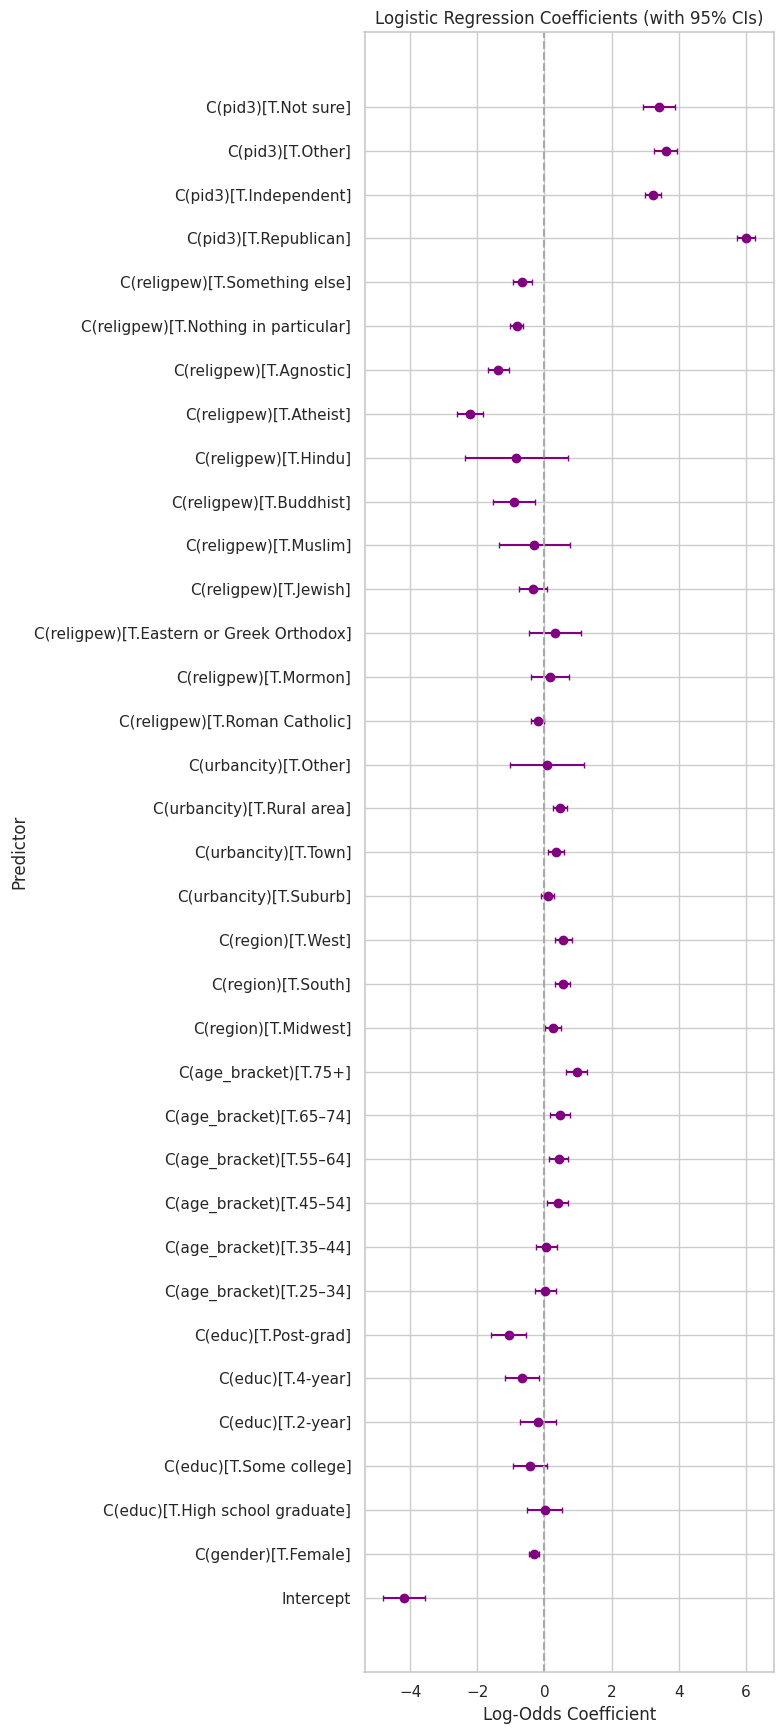

In [38]:
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Extract coefficients and confidence intervals (already in log-odds)
params = ces20_model2.params

# filter to only include params that contain "race"
# params = params[params.index.str.contains('race')]

conf = ces20_model2.conf_int()
conf.columns = ['CI Lower', 'CI Upper']

# Step 2: Combine into DataFrame
coef_df = pd.DataFrame({
    'Coefficient': params,
    'CI Lower': conf['CI Lower'],
    'CI Upper': conf['CI Upper'],
})
coef_df['Variable'] = coef_df.index

# Optional: sort variables for visual clarity
# coef_df = coef_df.sort_values(by='Coefficient')

# Step 3: Plot on log scale (i.e., raw coefficient scale)
plt.figure(figsize=(8, len(coef_df) * 0.5))
sns.set(style="whitegrid")

plt.errorbar(
    coef_df['Coefficient'],
    coef_df['Variable'],
    xerr=[coef_df['Coefficient'] - coef_df['CI Lower'],
          coef_df['CI Upper'] - coef_df['Coefficient']],
    fmt='o',
    color='purple',
    ecolor='purple',
    capsize=2
)

# Add reference line at 0 (i.e., no effect on log-odds scale)
plt.axvline(x=0, color='darkgray', linestyle='--')

# Formatting
plt.xlabel('Log-Odds Coefficient')
plt.ylabel('Predictor')
plt.title('Logistic Regression Coefficients (with 95% CIs)')
plt.tight_layout()
plt.show()
